In [12]:
import pdb
import glob
import copy
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

## Specify data directories. 

According to Andrew Schuh:

> File locations on hercules:
> 
> `/work/noaa/co2/aschuh/WOMBAT_stuff/wombat-v3-forward`
> 
> `/work/noaa/co2/aschuh/WOMBAT_stuff/wombat-v3-inverse`
> 
> 4D Jacobian fields will be in `forward` and the postprocessed observational Jacobians will be in `inverse`.

> The TM5 versions are in
> 
> `/work/noaa/co2/andy/Projects/WOMBAT/wombat-v3-forward`
> 
> Transport stuff is in 3b. Output sensitivities are in 4b.

And according to Mike Bertolacci:

> There are three run directories, all in
>
> `3a_transport_gc/intermediates`:
> 
> - `runs`: most of the basis-function runs are here. These are split out by gpp/resp/ocean, region, pft for resp and gpp, component (intercept/trend/sin/cos/residual), and for the residual by month. Some combinations of region and pft are omitted due to negligible fluxes.
>
> - `runs-correction`: adds a few cases missing from the above
>
> - `runs-control`: has "control runs" where each major component + inventory is run, plus fires and fossil fluxes. These are not split out by region or month, and cover some cases that are omitted in the jacobian due to negligible fluxes.


In [13]:
data_dir = '/work/noaa/co2/aschuh/WOMBAT_stuff'
inverse_dir = f'{data_dir}/wombat-v3-inverse'
forward_dir = f'{data_dir}/wombat-v3-forward'
gc_transport_dir = f'{forward_dir}/3a_transport_gc/intermediates/runs'

## Choose source, read components via tracer mappings from file

According to Mike:

> For each run directory there is a mapping.csv file that tells you how things work.

> The first few lines are:
>
> `---`
> 
> `basis_function, run, species`
> 
> `background_climatology_20140901, climatology_20140901_part001, r0001p001s001`
> 
>`ocean_intercept_regionRegion01, climatology_20140901_part001, r0001p001s002`
>
> `---`
>
> Here:
> 
> - The first column tells you the name of the basis function
> 
> - The second column tells you which run directory to find it in
>
> - The third column tells you the tracer name within that run
>
> - Here, the first `background` row is a simple run with no fluxes starting with a 400ppm IC
>
> - The second row is one for the ocean intercept in region 1 (you can tell from the name).
>
> All basis function runs start from a 400ppm IC


> Let's try to find the `ocean_intercept_regionRegion01` tracer:
> 
> - In `3a_transport_gc/intermediates/runs/` you will find directories like: `climatology_20140901_part001_split01`, `climatology_20140901_part001_split02`, and so on
>
> - This is a split over time, here each run runs for 3 months
Inside each directory you can find an `OutputDir`, which has daily files like `GEOSChem.SpeciesConcThreeHourly.YYYYMMDD_0000z.nc4`; these are the 3 hourly concentrations
>
> - In these files you will find `SpeciesConcVV_r0001p001s002` (among others). Matching up to the `mapping.csv`, you can tell this is for `ocean_intercept_regionRegion01`
>
> To post-process these files to get the jacobian, you just need to subtract 400ppm off them.


In [14]:
# get mapping file
mapping = pd.read_csv(f'{gc_transport_dir}/mapping.csv')

# choose source, region, split
source = 'bio_gpp'
pft    = 5 # plant functional type; 4 or 5
extra  = f'_pft{pft:02d}'
region = 2 # region 2 is CONUS
split  = 1

# lambda function for formatting file names per input component
fname = lambda component: f'{source}_{component}{extra}_regionRegion{region:02d}'

# make dict of component labels -> component names
comp_labels = ['intercept', 'trend', 'sin1', 'sin2', 'sin3', 'cos1', 'cos2', 'cos3']
comp_names  = dict(zip(comp_labels, ['intercept', 'trend', 
                                     'sin12_1', 'sin12_2', 'sin12_3', 
                                     'cos12_1', 'cos12_2', 'cos12_3']))

# make dict of component labels -> maps
comp_maps = dict(zip(comp_labels, [mapping[mapping['basis_function'] == fname(comp_names[comp])] 
                               for comp in comp_labels]))
comp_runs = dict(zip(comp_labels, [comp_maps[comp]['run'].iat[0] for comp in comp_labels]))
comp_species = dict(zip(comp_labels, [comp_maps[comp]['species'].iat[0] for comp in comp_labels]))

In [15]:
comp_maps['intercept']

,basis_function,run,species
76,bio_gpp_intercept_pft05_regionRegion02,climatology_20140901_part004,r0001p004s005


In [16]:
comp_data = {}
for i,comp in enumerate(comp_labels):
    data_files = sorted(glob.glob(f'{gc_transport_dir}/{comp_runs[comp]}_split0{split}'\
                                   '/OutputDir/GEOSChem.SpeciesConcThreeHourly*'))
    print(f'reading {comp} files')
    data = [0]*len(data_files)
    for i in range(len(data_files)):
        data_3hr = xr.open_dataset(data_files[i])[f'SpeciesConcVV_{comp_species[comp]}']
        data[i]  = data_3hr.coarsen(time=8, boundary='trim').mean()
        data[i]  = (data[i]*1e6) - 400 # convert to ppm and subtract 400ppm
        print(f'{i+1}/{len(data_files)}', end=['\r','\n'][i==len(data_files)-1])
    print(f'concatenating')
    data = xr.concat(data, dim='time')
    comp_data[comp] = data

reading intercept files
122/122
concatenating
reading trend files
122/122
concatenating
reading sin1 files
122/122
concatenating
reading sin2 files
122/122
concatenating
reading sin3 files
122/122
concatenating
reading cos1 files
122/122
concatenating
reading cos2 files
122/122
concatenating
reading cos3 files
122/122
concatenating


In [17]:
aalat, aalon = 42, 277
ilev=10

time = comp_data['trend'].time
days = np.arange(len(time))
days = days[:, None, None, None]
lat  = comp_data['trend'].lat
lon  = comp_data['trend'].lon
lev  = comp_data['trend'].lev
levels = comp_data['trend']

# scale sin and cos pieces?
print('scaling seasonal pieces')
data_scaled = copy.deepcopy(comp_data)
data_scaled['sin1'] = data_scaled['sin1'] * np.sin(2*np.pi*1*days/365.25)
data_scaled['sin2'] = data_scaled['sin2'] * np.sin(2*np.pi*2*days/365.25)
data_scaled['sin3'] = data_scaled['sin3'] * np.sin(2*np.pi*3*days/365.25)
data_scaled['cos1'] = data_scaled['cos1'] * np.cos(2*np.pi*1*days/365.25)
data_scaled['cos2'] = data_scaled['cos2'] * np.cos(2*np.pi*2*days/365.25)
data_scaled['cos3'] = data_scaled['cos3'] * np.cos(2*np.pi*3*days/365.25)

# get column-integrated
print('copying column-integrated')
x_data = copy.deepcopy(comp_data)
print('copying column-integrated scaled')
x_data_scaled = copy.deepcopy(data_scaled)
print('computing column-integrated')
for comp in comp_labels:
    x_data[comp] = comp_data[comp].sum('lev')
    x_data_scaled[comp] = data_scaled[comp].sum('lev')

#get zonal mean
print('copying zonal means')
zm_data = copy.deepcopy(comp_data)
print('copying zonal means scaled')
zm_data_scaled = copy.deepcopy(data_scaled)
print('computing zonal means')
for comp in comp_labels:
    zm_data[comp] = comp_data[comp].mean('lon')
    zm_data_scaled[comp] = data_scaled[comp].mean('lon')

scaling seasonal pieces
copying column-integrated
copying column-integrated scaled
computing column-integrated
copying zonal means
copying zonal means scaled
computing zonal means


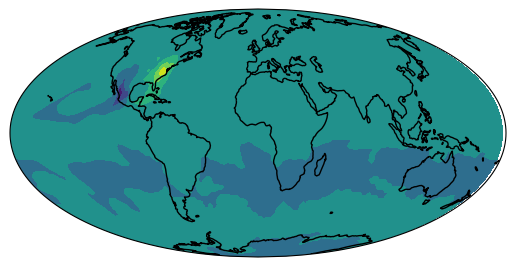

In [18]:

fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.Mollweide())
ax.contourf(lon, lat, comp_data['trend'].isel(time=100, lev=0), transform=ccrs.PlateCarree(), cmap='viridis')
ax.coastlines()
ax.set_global()

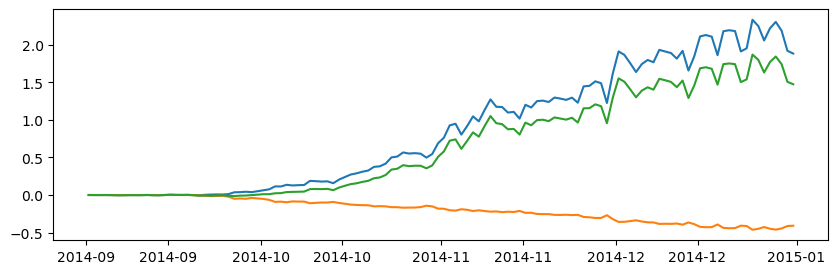

In [19]:
plt.figure(figsize=(10, 3))
plt.plot(time, (comp_data['intercept'] + comp_data['trend']*days).sel(lat=aalat, lon=aalon, method='nearest').isel(lev=0))
plt.plot(time, (data_scaled['sin1']+data_scaled['sin2']+data_scaled['sin3']+data_scaled['cos1']+data_scaled['cos2']+data_scaled['cos3']).sel(lat=aalat, lon=aalon, method='nearest').isel(lev=0))
plt.plot(time, (comp_data['intercept'] + comp_data['trend']*days + data_scaled['sin1']+data_scaled['sin2']+data_scaled['sin3']+data_scaled['cos1']+data_scaled['cos2']+data_scaled['cos3']).sel(lat=aalat, lon=aalon, method='nearest').isel(lev=0))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

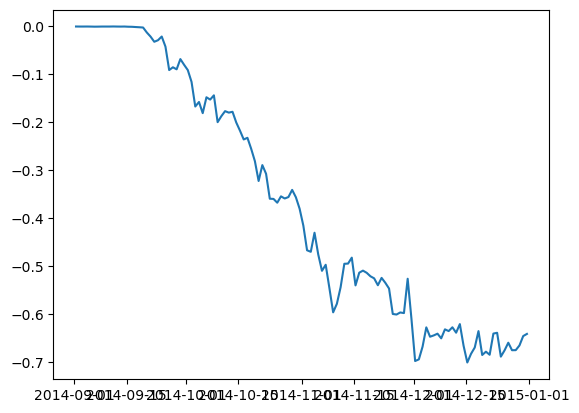

In [21]:
plt.plot(time, (comp_data['intercept']).sel(lat=aalat, lon=aalon, method='nearest').isel(lev=0))

In [23]:
(comp_data['intercept']).sel(lat=aalat, lon=aalon, method='nearest').

<xarray.DataArray 'lev' (lev: 47)> Size: 376B
array([9.925000e-01, 9.774999e-01, 9.624998e-01, 9.475000e-01, 9.325001e-01,
       9.174999e-01, 9.024999e-01, 8.875000e-01, 8.725000e-01, 8.575001e-01,
       8.425001e-01, 8.275002e-01, 8.100002e-01, 7.875000e-01, 7.625000e-01,
       7.375001e-01, 7.125001e-01, 6.875001e-01, 6.562501e-01, 6.187502e-01,
       5.812502e-01, 5.437501e-01, 5.062501e-01, 4.687501e-01, 4.312501e-01,
       3.937501e-01, 3.562501e-01, 3.127916e-01, 2.664790e-01, 2.265135e-01,
       1.925410e-01, 1.636615e-01, 1.391150e-01, 1.182500e-01, 1.005144e-01,
       8.543901e-02, 6.745011e-02, 4.828166e-02, 3.427161e-02, 2.407970e-02,
       1.454227e-02, 6.684757e-03, 2.863681e-03, 1.133785e-03, 4.140641e-04,
       1.386745e-04, 3.800000e-05])
Coordinates:
  * lev      (lev) float64 376B 0.9925 0.9775 0.9625 ... 0.0001387 3.8e-05
    lat      float64 8B 42.0
    lon      float64 8B 177.5
Attributes:
    long_name:      hybrid level at midpoints ((A/P0)+B)
    units:          level
    axis:           Z
    positive:       up
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    formula_terms:  a: hyam b: hybm p0: P0 ps: PS